Простая модель XGboost по прогнозу продаж вина
Против наивных моделей
Сработала плохо, но как пример

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
#from tsfresh import feature_extraction
%matplotlib inline
from sklearn.model_selection import GridSearchCV

### Monthly australian wine sales: thousands of litres (1980 - 1994)

In [7]:
df_wine = pd.read_csv('monthly-australian-wine-sales-th.csv', parse_dates=True, dayfirst=True)
df_wine.drop(df_wine.index[176], inplace=True)
df_wine.index = pd.to_datetime(df_wine.index)
df_wine['Month'] = df_wine.index.map(lambda x: x.month)

df_wine.columns = ['Monthly wine sale', 'Month']
df_wine['Monthly wine sale'] = df_wine['Monthly wine sale'].astype(float)
df_wine.head()

,Monthly wine sale,Month
1980-01-01,15136.0,1
1980-02-01,16733.0,2
1980-03-01,20016.0,3
1980-04-01,17708.0,4
1980-05-01,18019.0,5


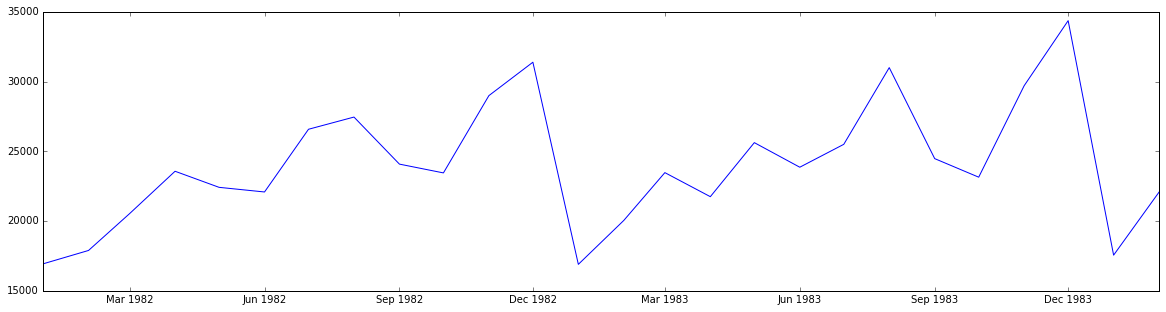

In [120]:
plt.figure(figsize=(20, 5))
plt.plot(df_wine["Monthly wine sale"][24:50])

In [8]:
df_wine = pd.concat([df_wine, pd.get_dummies(df_wine['Month'])], axis=1)
df_wine.head()

,Monthly wine sale,Month,1,2,3,4,5,6,7,8,9,10,11,12
1980-01-01,15136.0,1,1,0,0,0,0,0,0,0,0,0,0,0
1980-02-01,16733.0,2,0,1,0,0,0,0,0,0,0,0,0,0
1980-03-01,20016.0,3,0,0,1,0,0,0,0,0,0,0,0,0
1980-04-01,17708.0,4,0,0,0,1,0,0,0,0,0,0,0,0
1980-05-01,18019.0,5,0,0,0,0,1,0,0,0,0,0,0,0


In [9]:
avg = df_wine.groupby(by=df_wine['Month'])['Monthly wine sale'].mean()
df_wine['MonthAvg'] = df_wine.Month.map(lambda x: avg[df_wine['Month'][x-1]])
df_wine.head()

,Monthly wine sale,Month,1,2,3,4,5,6,7,8,9,10,11,12,MonthAvg
1980-01-01,15136.0,1,1,0,0,0,0,0,0,0,0,0,0,0,17174.400000
1980-02-01,16733.0,2,0,1,0,0,0,0,0,0,0,0,0,0,20366.066667
1980-03-01,20016.0,3,0,0,1,0,0,0,0,0,0,0,0,0,23445.466667
1980-04-01,17708.0,4,0,0,0,1,0,0,0,0,0,0,0,0,24266.000000
1980-05-01,18019.0,5,0,0,0,0,1,0,0,0,0,0,0,0,23594.933333


In [124]:
df_wine.drop(labels='Month', axis=1, inplace=True)

Применим наивный прогноз:

MSE =  21100464.454118498


Text(0, 0.5, 'Monthly wine sales')

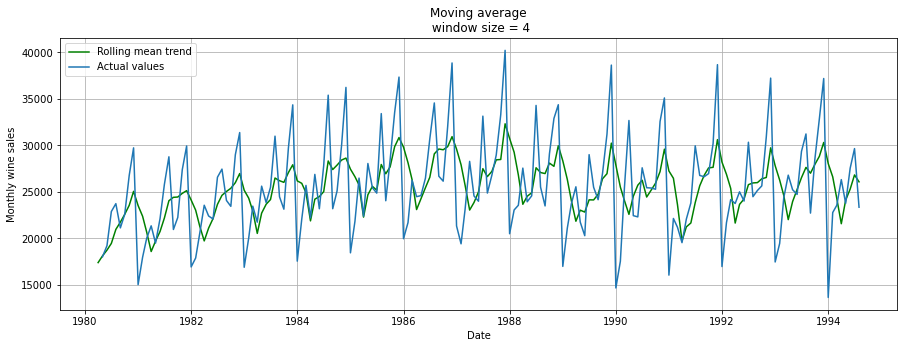

In [13]:
def moving_average(data, n):
    return np.average(data[-n:])

def plotMovingAverage(data, n):
    """
    series - dataframe with timeseries
    n - rolling window size 
    """

    rolling_mean = data.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(data[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

    MSE_MA = mean_squared_error(data[(n-1):], data.rolling(window=n).mean()[(n-1):])
    
    print('MSE = ', MSE_MA)

plotMovingAverage(df_wine['Monthly wine sale'], n=4)
plt.xlabel('Date')
plt.ylabel('Monthly wine sales')

MSE =  45850198.36571429


Text(0, 0.5, 'Monthly wine sales')

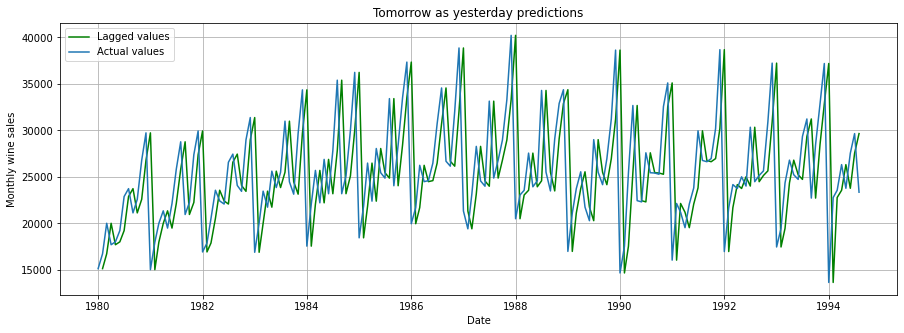

In [16]:
# затра будет, как вчера
def plotLag(data):
    lag_data = data.shift(periods=1)
    
    plt.figure(figsize=(15,5))
    plt.title("Tomorrow as yesterday predictions")
    plt.plot(lag_data, "g", label="Lagged values")
    
    plt.plot(data, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    
    MSE_lag = mean_squared_error(data[1:], lag_data[1:])
    print('MSE = ', MSE_lag)
    return

plotLag(df_wine['Monthly wine sale'])
plt.xlabel('Date')
plt.ylabel('Monthly wine sales')

In [18]:
months_lst = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
dataframe = df_wine[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'MonthAvg']]
dataframe.head()

,1,2,3,4,5,6,7,8,9,10,11,12,MonthAvg
1980-01-01,1,0,0,0,0,0,0,0,0,0,0,0,17174.400000
1980-02-01,0,1,0,0,0,0,0,0,0,0,0,0,20366.066667
1980-03-01,0,0,1,0,0,0,0,0,0,0,0,0,23445.466667
1980-04-01,0,0,0,1,0,0,0,0,0,0,0,0,24266.000000
1980-05-01,0,0,0,0,1,0,0,0,0,0,0,0,23594.933333


In [19]:
df_wine.drop(labels=[1, 2, 3, 4, 5 ,6, 7, 8 ,9, 10, 11, 12, 'MonthAvg'], axis=1, inplace=True)

Text(0, 0.5, 'Monthly wine sales')

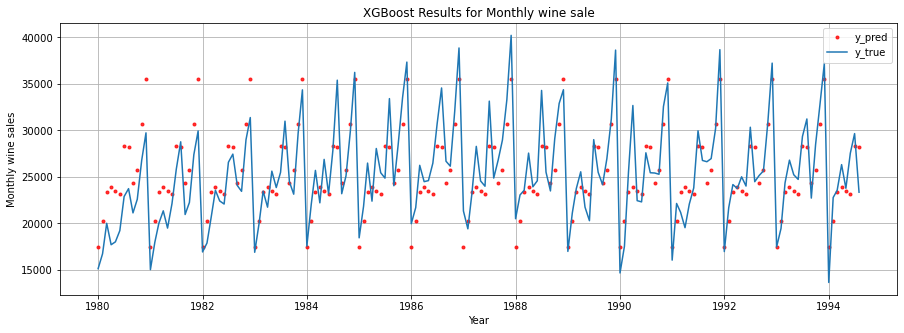

In [30]:
gbm = XGBRegressor()
res = gbm.fit(dataframe[:'1992'], df_wine['Monthly wine sale'].loc[:'1992'])
y_pred = pd.DataFrame(data=gbm.predict(dataframe))
y_pred.index = df_wine.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(df_wine['Monthly wine sale'], label="y_true")
plt.axis('tight')
plt.grid(True)

plt.legend()
plt.title('XGBoost Results for Monthly wine sale')
plt.xlabel('Year')
plt.ylabel('Monthly wine sales')

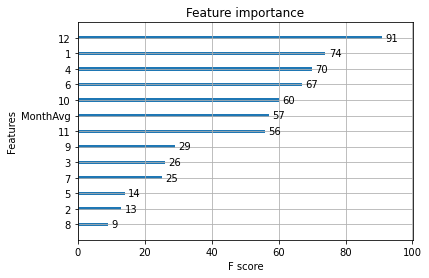

In [31]:
xgb.plot_importance(gbm)

In [44]:
mse_train = mean_squared_error(df_wine.loc[:'1992']['Monthly wine sale'], y_pred[:'1992'])
mse_test = mean_squared_error(df_wine.loc['1992':]['Monthly wine sale'], y_pred['1992':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  7299844.552274361
MSE test = 4432813.896295905


Получили совсем плохую модель, но это тоже важное знание!(Нет) :)

In [57]:
df_t_1 = temps.shift(1)
df_t_1.index = df_wine.index

differenced = pd.DataFrame(data=(df_wine['Monthly wine sale'] - df_t_1[0]), index=df_wine.index )
differenced.columns= ['Monthly wine sale']
differenced.head()

,Monthly wine sale
1980-01-01,NaN
1980-02-01,1597.0
1980-03-01,3283.0
1980-04-01,-2308.0
1980-05-01,311.0


In [58]:
differenced.dropna(inplace=True)

Привели ряд к стационарности

In [60]:
differenced['Month'] = differenced.index.map(lambda x: x.month)
avg_dif = differenced.groupby(by=differenced['Month'])['Monthly wine sale'].mean()
differenced['MonthAvg'] = differenced.Month.map(lambda x: avg_dif[differenced['Month'][x-1]])

In [61]:
differenced.groupby(by=differenced['Month'])['Monthly wine sale'].mean()

Month
1    -18350.000000
2      3191.666667
3      3079.400000
4       820.533333
5      -671.066667
6       -12.533333
7      4924.000000
8      -402.000000
9     -4230.357143
10     1685.714286
11     4991.571429
12     4779.500000
Name: Monthly wine sale, dtype: float64

In [62]:
differenced.head()

,Monthly wine sale,Month,MonthAvg
1980-02-01,1597.0,2,3079.400000
1980-03-01,3283.0,3,820.533333
1980-04-01,-2308.0,4,-671.066667
1980-05-01,311.0,5,-12.533333
1980-06-01,1208.0,6,4924.000000


In [63]:
dataframe_dif = dataframe
dataframe_dif.drop(labels='MonthAvg', axis=1, inplace=True)
dataframe_dif['MthAvg'] = differenced['MonthAvg']
differenced.drop(labels=['Month', 'MonthAvg'], axis=1, inplace=True)

C:\Users\vzhyvov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\vzhyvov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
temps = pd.DataFrame(differenced.values)
mnth = pd.DataFrame(dataframe_dif.values)
dataframe_diff = pd.concat([temps.shift(3), temps.shift(2), temps.shift(1), mnth], axis=1)
dataframe_diff.columns = ['t-3', 't-2', 't-1', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', 'MonthAvg']
dataframe_diff.index = df_wine.index

In [65]:
dataframe_dif.dropna(inplace=True)

C:\Users\vzhyvov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
dataframe_diff.index = df_wine.index

In [67]:
dataframe_diff.head()

,t-3,t-2,t-1,01,02,03,04,05,06,07,08,09,10,11,12,MonthAvg
1980-01-01,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1980-02-01,NaN,NaN,1597.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3079.400000
1980-03-01,NaN,1597.0,3283.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,820.533333
1980-04-01,1597.0,3283.0,-2308.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-671.066667
1980-05-01,3283.0,-2308.0,311.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.533333


In [69]:
gbm = XGBRegressor()
res = gbm.fit(dataframe_diff["1980-02-01":'1988-04-01'], differenced.loc[:'1988-04-01'])

Text(0, 0.5, 'Monthly wine sales')

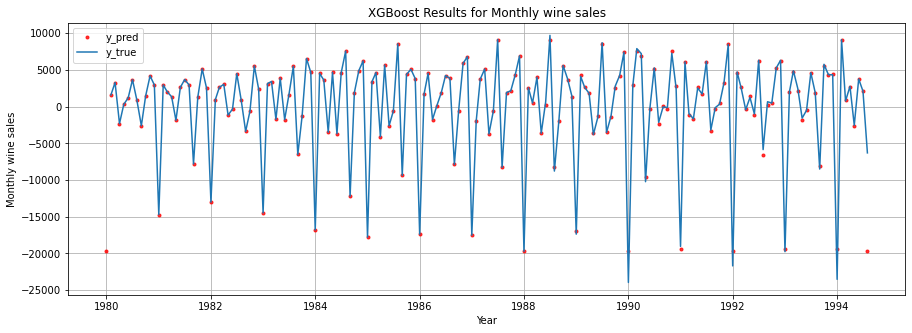

In [71]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe_diff))
y_pred.index = df_wine.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "r.", alpha=0.8, label="y_pred")
plt.plot(differenced, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающуей и тестовой выборок
#plt.axvline(x='1988-04-01', color='black',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Monthly wine sales')
plt.xlabel('Year')
plt.ylabel('Monthly wine sales')

In [72]:
mse_train = mean_squared_error(differenced.loc["1980-02-01":'1994-04-01'], y_pred["1980-02-01":'1994-04-01'])
mse_test = mean_squared_error(differenced.loc['1994-04-01':], y_pred['1994-04-01':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  248290.92633687303
MSE test = 35856062.611640416


In [73]:
y_pred[1] = [0] * y_pred.shape[0]
y_pred[1]["1980-01-01"] = df_wine['Monthly wine sale']["1980-01-01"]
y_pred.head()

C:\Users\vzhyvov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,0,1
1980-01-01,-19692.988281,15136
1980-02-01,1597.004150,0
1980-03-01,3282.957520,0
1980-04-01,-2307.812744,0
1980-05-01,310.920715,0


In [74]:
# восстановим истинные значени

for i in range(y_pred.shape[0]-1):
    y_pred[1].iloc[i+1] = y_pred[1].iloc[i] + y_pred[0].iloc[i+1]
y_pred.head()

C:\Users\vzhyvov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,0,1
1980-01-01,-19692.988281,15136.000000
1980-02-01,1597.004150,16733.004150
1980-03-01,3282.957520,20015.961670
1980-04-01,-2307.812744,17708.148926
1980-05-01,310.920715,18019.069641


Text(0, 0.5, 'Monthly wine sales')

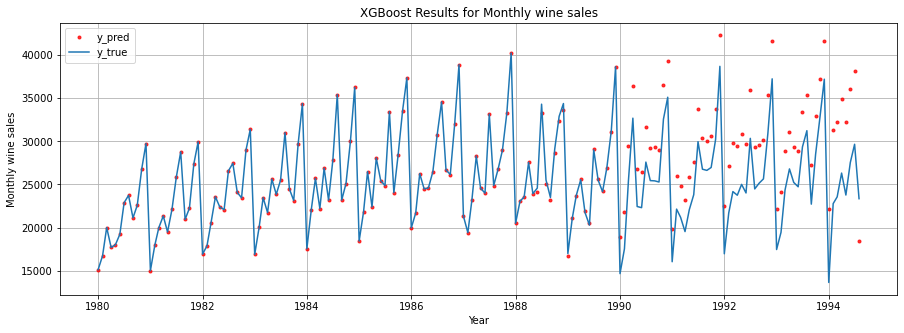

In [76]:
plt.figure(figsize=(15, 5))
plt.plot(y_pred[1], "r.", alpha=0.8, label="y_pred")
plt.plot(df_wine['Monthly wine sale'], label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающуей и тестовой выборок
#plt.axvline(x='1988-04-01', color='grey',  linewidth=2, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for Monthly wine sales')
plt.xlabel('Year')
plt.ylabel('Monthly wine sales')

In [77]:
mse_train = mean_squared_error(df_wine['Monthly wine sale'].loc[:'1994-04-01'], y_pred[1][:'1994-04-01'])
mse_test = mean_squared_error(df_wine['Monthly wine sale'].loc['1994-04-01':], y_pred[1]['1994-04-01':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  7048197.70090631
MSE test = 62899591.886891924
